# Autoencoder

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prep data

In [3]:
raw_data = np.loadtxt("../data/shuffled_data/repeat_shuffle_train.csv", delimiter=",", dtype=float)

In [4]:
raw_data = torch.tensor(raw_data).float() # convert to float32

In [5]:
NN = 10
data = raw_data.T[:,:NN] # take first NN neurons for now
data.shape

torch.Size([226814, 10])

In [6]:
# split into training and validation data
np.random.seed(42)
split = int(0.8 * data.shape[0])
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
train_data = data[indices[:split]]
val_data = data[indices[split:]]

In [7]:
BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)

## Define model

In [49]:
def init_weights(layer):
    torch.nn.init.zeros_(layer.bias)
    torch.nn.init.orthogonal_(layer.weight)

In [50]:
class VariationalEncoder(nn.Module):
    def __init__(self, 
                 enc_layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [160,10,2]",
                 mu_layer_dims: "list of at least 2 ints specifying dims for network for learning mus",
                 sigma_layer_dims: "list of at least 2 ints specifying dims for network for learning mus"):
        super(VariationalEncoder, self).__init__()
        
        self.enc_layers = nn.ModuleList([])
        self.mu_layers = nn.ModuleList([])
        self.sigma_layers = nn.ModuleList([])
        
        for i in range(1,len(enc_layer_dims)):
            self.enc_layers.append(nn.Linear(enc_layer_dims[i-1], enc_layer_dims[i]))
            init_weights(self.enc_layers[-1])
            
        for i in range(1,len(mu_layer_dims)):
            self.mu_layers.append(nn.Linear(mu_layer_dims[i-1], mu_layer_dims[i]))
            init_weights(self.mu_layers[-1])
            
        for i in range(1,len(sigma_layer_dims)):
            self.sigma_layers.append(nn.Linear(sigma_layer_dims[i-1], sigma_layer_dims[i]))
            init_weights(self.sigma_layers[-1])
        
        # also define standard normal dist for sampling
        self.N = torch.distributions.Normal(0, 1)
#         self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
#         self.N.scale = self.N.scale.cuda()
        self.kl = 0
    
    def forward(self, x):
        for layer in self.enc_layers[:-1]: # encode
            x = F.relu(layer(x))
        x =  self.enc_layers[-1](x)
        
        # map encoding to mu
        mu = x
        for layer in self.mu_layers[:-1]: # map encoding to mus
            mu = F.relu(layer(mu))
        mu = self.mu_layers[-1](mu)
        
        # map encoding to sigma
        sigma = x
        for layer in self.sigma_layers[:-1]: # map encoding to sigma
            sigma = F.relu(layer(sigma))
        sigma = torch.exp( self.sigma_layers[-1](sigma) )
        
        # sample from latent dist
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [51]:
class Decoder(nn.Module):
    def __init__(self, 
                layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [2,4,160]"):
        super(Decoder, self).__init__()
        
        self.layers = nn.ModuleList([])
        for i in range(1,len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            init_weights(self.layers[-1])
        
    def forward(self, z):
        for layer in self.layers[:-1]: # decode
            z = F.relu(layer(z))
        z = self.layers[-1](z) # don't apply activation on last layer
        z = torch.sigmoid(z) #squish
        return z

In [52]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, 
                 enc_layer_dims, 
                 mu_layer_dims,
                 sigma_layer_dims,
                 decoder_layer_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(enc_layer_dims, mu_layer_dims, sigma_layer_dims)
        self.decoder = Decoder(decoder_layer_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [53]:
ae = VariationalAutoencoder([NN,4,2],
                            [2,2],
                            [2,2],
                            [2,4,NN])
batch = next(iter(train_data_loader))
reconstruction = ae(batch)
torch.round(reconstruction)

tensor([[1., 1., 1., 1., 1., 1., 1., 0., 1., 0.],
        [1., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
        [1., 1., 1., 0., 1., 0., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 0.],
        [1., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
        [0., 1., 1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 0., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
        [1., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0., 0., 1., 1., 0.],
        [1., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 1., 1.],
        [1., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
        [1., 0., 1., 0., 1., 1., 1., 0., 1., 1.],


## Define training loop

In [54]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        epoch_loss = 0
        for x in tqdm(data):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
            
            epoch_loss += loss
            
        print(f"Train loss: {np.round(epoch_loss.detach().cpu().numpy(),2)}")
        
    return autoencoder

Define model

In [55]:
torch.manual_seed(0)
# define model
NNs = train_data.shape[1]
latent_dims = 2
enc_layer_dims = [NNs,20,latent_dims]
mu_layer_dims = [latent_dims, latent_dims]
sigma_layer_dims = [latent_dims, latent_dims]
decoder_layer_dims = [latent_dims,20,NNs]
ae = VariationalAutoencoder(encoder_layer_dims,mu_layer_dims,sigma_layer_dims,decoder_layer_dims).to(device) # GPU

In [34]:
zero_data_loader = torch.utils.data.DataLoader(torch.zeros((100,NNs)), batch_size=BATCH_SIZE)

In [59]:
ae = train(ae,zero_data_loader,100)

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 442.34it/s]


Train loss: 70.55999755859375


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 760.91it/s]


Train loss: 70.41999816894531


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 998.82it/s]


Train loss: 70.33999633789062


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 938.32it/s]


Train loss: 70.25


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 979.63it/s]


Train loss: 70.16999816894531


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1113.58it/s]


Train loss: 70.11000061035156


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1079.34it/s]


Train loss: 70.02999877929688


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 743.37it/s]


Train loss: 69.97000122070312


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1092.91it/s]


Train loss: 69.93000030517578


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1073.54it/s]


Train loss: 69.87000274658203


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 818.80it/s]


Train loss: 69.83000183105469


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1057.43it/s]


Train loss: 69.80000305175781


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1101.37it/s]


Train loss: 69.76000213623047


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 759.91it/s]


Train loss: 69.73999786376953


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1034.48it/s]


Train loss: 69.69999694824219


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 979.46it/s]


Train loss: 69.68000030517578


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 841.09it/s]


Train loss: 69.66000366210938


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1024.31it/s]


Train loss: 69.63999938964844


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1057.90it/s]


Train loss: 69.62000274658203


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 864.31it/s]


Train loss: 69.5999984741211


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1051.27it/s]


Train loss: 69.58999633789062


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1040.90it/s]


Train loss: 69.56999969482422


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1074.36it/s]


Train loss: 69.55999755859375


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 708.95it/s]


Train loss: 69.55000305175781


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 804.16it/s]


Train loss: 69.54000091552734


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1071.82it/s]


Train loss: 69.52999877929688


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 788.77it/s]


Train loss: 69.5199966430664


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1029.59it/s]


Train loss: 69.51000213623047


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1110.19it/s]


Train loss: 69.5


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 796.64it/s]


Train loss: 69.48999786376953


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1066.98it/s]


Train loss: 69.48999786376953


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1194.02it/s]


Train loss: 69.4800033569336


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 910.91it/s]


Train loss: 69.47000122070312


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 761.74it/s]


Train loss: 69.45999908447266


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1053.18it/s]


Train loss: 69.45999908447266


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1066.10it/s]


Train loss: 69.44999694824219


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1084.64it/s]


Train loss: 69.44999694824219


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1115.14it/s]


Train loss: 69.44000244140625


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1070.66it/s]


Train loss: 69.44000244140625


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 944.08it/s]


Train loss: 69.43000030517578


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1103.40it/s]


Train loss: 69.43000030517578


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1104.64it/s]


Train loss: 69.43000030517578


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 829.00it/s]


Train loss: 69.41999816894531


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 908.01it/s]


Train loss: 69.41999816894531


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1035.25it/s]


Train loss: 69.41999816894531


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 830.72it/s]


Train loss: 69.41000366210938


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 951.90it/s]


Train loss: 69.41000366210938


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1076.15it/s]


Train loss: 69.41000366210938


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 865.03it/s]


Train loss: 69.4000015258789


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 936.39it/s]


Train loss: 69.4000015258789


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1139.21it/s]


Train loss: 69.4000015258789


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1051.27it/s]


Train loss: 69.4000015258789


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1044.14it/s]


Train loss: 69.38999938964844


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1181.08it/s]


Train loss: 69.38999938964844


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1104.71it/s]


Train loss: 69.38999938964844


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 979.69it/s]


Train loss: 69.38999938964844


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 963.88it/s]


Train loss: 69.38999938964844


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 754.81it/s]


Train loss: 69.37999725341797


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 925.03it/s]


Train loss: 69.37999725341797


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 989.86it/s]


Train loss: 69.37999725341797


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1140.84it/s]


Train loss: 69.37999725341797


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1128.71it/s]


Train loss: 69.37999725341797


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 933.26it/s]


Train loss: 69.37999725341797


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1090.85it/s]


Train loss: 69.37000274658203


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 778.34it/s]


Train loss: 69.37000274658203


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 948.99it/s]


Train loss: 69.37000274658203


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1075.88it/s]


Train loss: 69.37000274658203


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1096.48it/s]


Train loss: 69.37000274658203


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 948.08it/s]


Train loss: 69.37000274658203


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 933.31it/s]


Train loss: 69.37000274658203


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1098.56it/s]


Train loss: 69.37000274658203


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1129.93it/s]


Train loss: 69.36000061035156


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 913.64it/s]


Train loss: 69.36000061035156


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1022.75it/s]


Train loss: 69.36000061035156


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1170.94it/s]


Train loss: 69.36000061035156


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 844.43it/s]


Train loss: 69.36000061035156


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1057.90it/s]


Train loss: 69.36000061035156


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 754.27it/s]


Train loss: 69.36000061035156


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 899.73it/s]


Train loss: 69.36000061035156


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 974.85it/s]


Train loss: 69.36000061035156


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1158.01it/s]


Train loss: 69.36000061035156


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1009.03it/s]


Train loss: 69.36000061035156


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1061.92it/s]


Train loss: 69.3499984741211


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 924.01it/s]


Train loss: 69.3499984741211


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1149.75it/s]


Train loss: 69.3499984741211


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 890.70it/s]


Train loss: 69.3499984741211


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1155.06it/s]


Train loss: 69.3499984741211


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1129.93it/s]


Train loss: 69.3499984741211


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 833.61it/s]


Train loss: 69.3499984741211


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 955.10it/s]


Train loss: 69.3499984741211


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1153.15it/s]


Train loss: 69.3499984741211


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1201.89it/s]


Train loss: 69.3499984741211


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 729.60it/s]


Train loss: 69.3499984741211


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1060.51it/s]


Train loss: 69.3499984741211


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1107.11it/s]


Train loss: 69.3499984741211


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 882.64it/s]


Train loss: 69.3499984741211


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 914.49it/s]


Train loss: 69.3499984741211


100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 1100.43it/s]


Train loss: 69.33999633789062


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 937.22it/s]


Train loss: 69.33999633789062


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 997.28it/s]

Train loss: 69.33999633789062


In [63]:
ae = train(ae,train_data_loader,100)

100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2088.10it/s]


Train loss: 171240.375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2118.29it/s]


Train loss: 171238.578125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2124.16it/s]


Train loss: 171238.640625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2133.88it/s]


Train loss: 171239.546875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2120.00it/s]


Train loss: 171238.421875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2130.56it/s]


Train loss: 171239.28125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2075.40it/s]


Train loss: 171237.984375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2060.68it/s]


Train loss: 171239.046875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2104.17it/s]


Train loss: 171237.875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2062.84it/s]


Train loss: 171238.140625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1934.30it/s]


Train loss: 171238.09375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1964.41it/s]


Train loss: 171238.421875


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1880.46it/s]


Train loss: 171238.234375


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1852.79it/s]


Train loss: 171239.234375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1981.28it/s]


Train loss: 171237.15625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1973.78it/s]


Train loss: 171237.078125


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1875.10it/s]


Train loss: 171237.125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2070.23it/s]


Train loss: 171237.078125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1979.19it/s]


Train loss: 171238.625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2147.44it/s]


Train loss: 171237.78125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2020.75it/s]


Train loss: 171239.421875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2053.44it/s]


Train loss: 171236.921875


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1685.89it/s]


Train loss: 171238.484375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2072.32it/s]


Train loss: 171238.1875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2018.25it/s]


Train loss: 171237.765625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2074.16it/s]


Train loss: 171238.40625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2072.25it/s]


Train loss: 171237.234375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2045.32it/s]


Train loss: 171237.8125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2014.95it/s]


Train loss: 171237.234375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2061.49it/s]


Train loss: 171237.359375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2016.54it/s]


Train loss: 171237.453125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2082.87it/s]


Train loss: 171237.078125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2078.59it/s]


Train loss: 171236.8125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2100.16it/s]


Train loss: 171236.546875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2078.59it/s]


Train loss: 171237.59375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2076.21it/s]


Train loss: 171237.015625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2101.04it/s]


Train loss: 171237.046875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2084.92it/s]


Train loss: 171236.546875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2101.06it/s]


Train loss: 171235.859375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2083.80it/s]


Train loss: 171236.5625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2074.47it/s]


Train loss: 171237.234375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2056.09it/s]


Train loss: 171235.546875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2066.64it/s]


Train loss: 171236.734375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2067.55it/s]


Train loss: 171236.78125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2076.96it/s]


Train loss: 171238.09375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2071.70it/s]


Train loss: 171237.28125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2083.42it/s]


Train loss: 171236.3125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2016.98it/s]


Train loss: 171235.921875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2004.12it/s]


Train loss: 171236.578125


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1855.32it/s]


Train loss: 171235.0625


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1691.19it/s]


Train loss: 171236.265625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2061.62it/s]


Train loss: 171235.59375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2068.57it/s]


Train loss: 171236.546875


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2013.26it/s]


Train loss: 171237.4375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2014.21it/s]


Train loss: 171236.453125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2050.65it/s]


Train loss: 171235.703125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2057.03it/s]


Train loss: 171235.84375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2077.99it/s]


Train loss: 171235.09375


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2099.70it/s]


Train loss: 171235.578125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2078.89it/s]


Train loss: 171235.90625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2043.22it/s]


Train loss: 171235.40625


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2073.58it/s]


Train loss: 171235.453125


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2020.74it/s]


Train loss: 171235.234375


  7%|██▊                                   | 422/5671 [00:00<00:02, 2016.04it/s]


KeyboardInterrupt: 

## Visualise latent representations

In [64]:
def plot_latent(autoencoder, data):
    """
        Plots the latent representation of states, colouring states by how many neurons fire
        data should be a SxN tensor where S is the number of states and N the number of neurons
    """
    Ks = data.sum(axis=1).detach().numpy() #how many neurons fired in each state
    z = ae.encoder(data).detach().numpy() #SxL where L is the latent dimensions
    cmap = plt.get_cmap('RdBu', np.max(Ks)-np.min(Ks)+1)
    plt.scatter(z[:,0],z[:,1],c=Ks,marker=".",cmap=cmap)
    plt.colorbar()

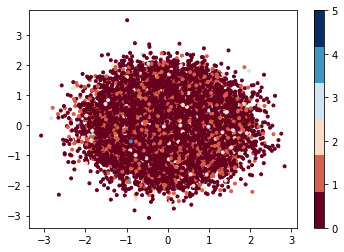

In [65]:
plot_latent(ae, val_data)

In [66]:
latent_samples = ae.encoder.N.sample(torch.Size([100,latent_dims]))

In [72]:
outputs = torch.round(ae.decoder(sample))

In [76]:
outputs.mean(axis=0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<MeanBackward1>)

In [75]:
val_data.mean(axis=0)

tensor([0.0274, 0.0084, 0.0150, 0.0163, 0.0221, 0.0217, 0.0242, 0.0800, 0.0411,
        0.0056])